<a href="https://colab.research.google.com/github/Prajay404/QCNNFORQSO/blob/main/QuasarQuantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 92.1 MB/s eta 0:00:00


Epoch [10/50], Train Loss: 0.9034, Train Accuracy: 0.5928, Test Loss: 0.9387, Test Accuracy: 0.5330
Epoch [20/50], Train Loss: 0.8601, Train Accuracy: 0.6142, Test Loss: 0.8972, Test Accuracy: 0.6100
Epoch [30/50], Train Loss: 0.8313, Train Accuracy: 0.6502, Test Loss: 0.8701, Test Accuracy: 0.6480
Epoch [40/50], Train Loss: 0.8112, Train Accuracy: 0.6756, Test Loss: 0.8514, Test Accuracy: 0.6600
Epoch [50/50], Train Loss: 0.7967, Train Accuracy: 0.6908, Test Loss: 0.8379, Test Accuracy: 0.6570
Final Test Accuracy: 0.6570


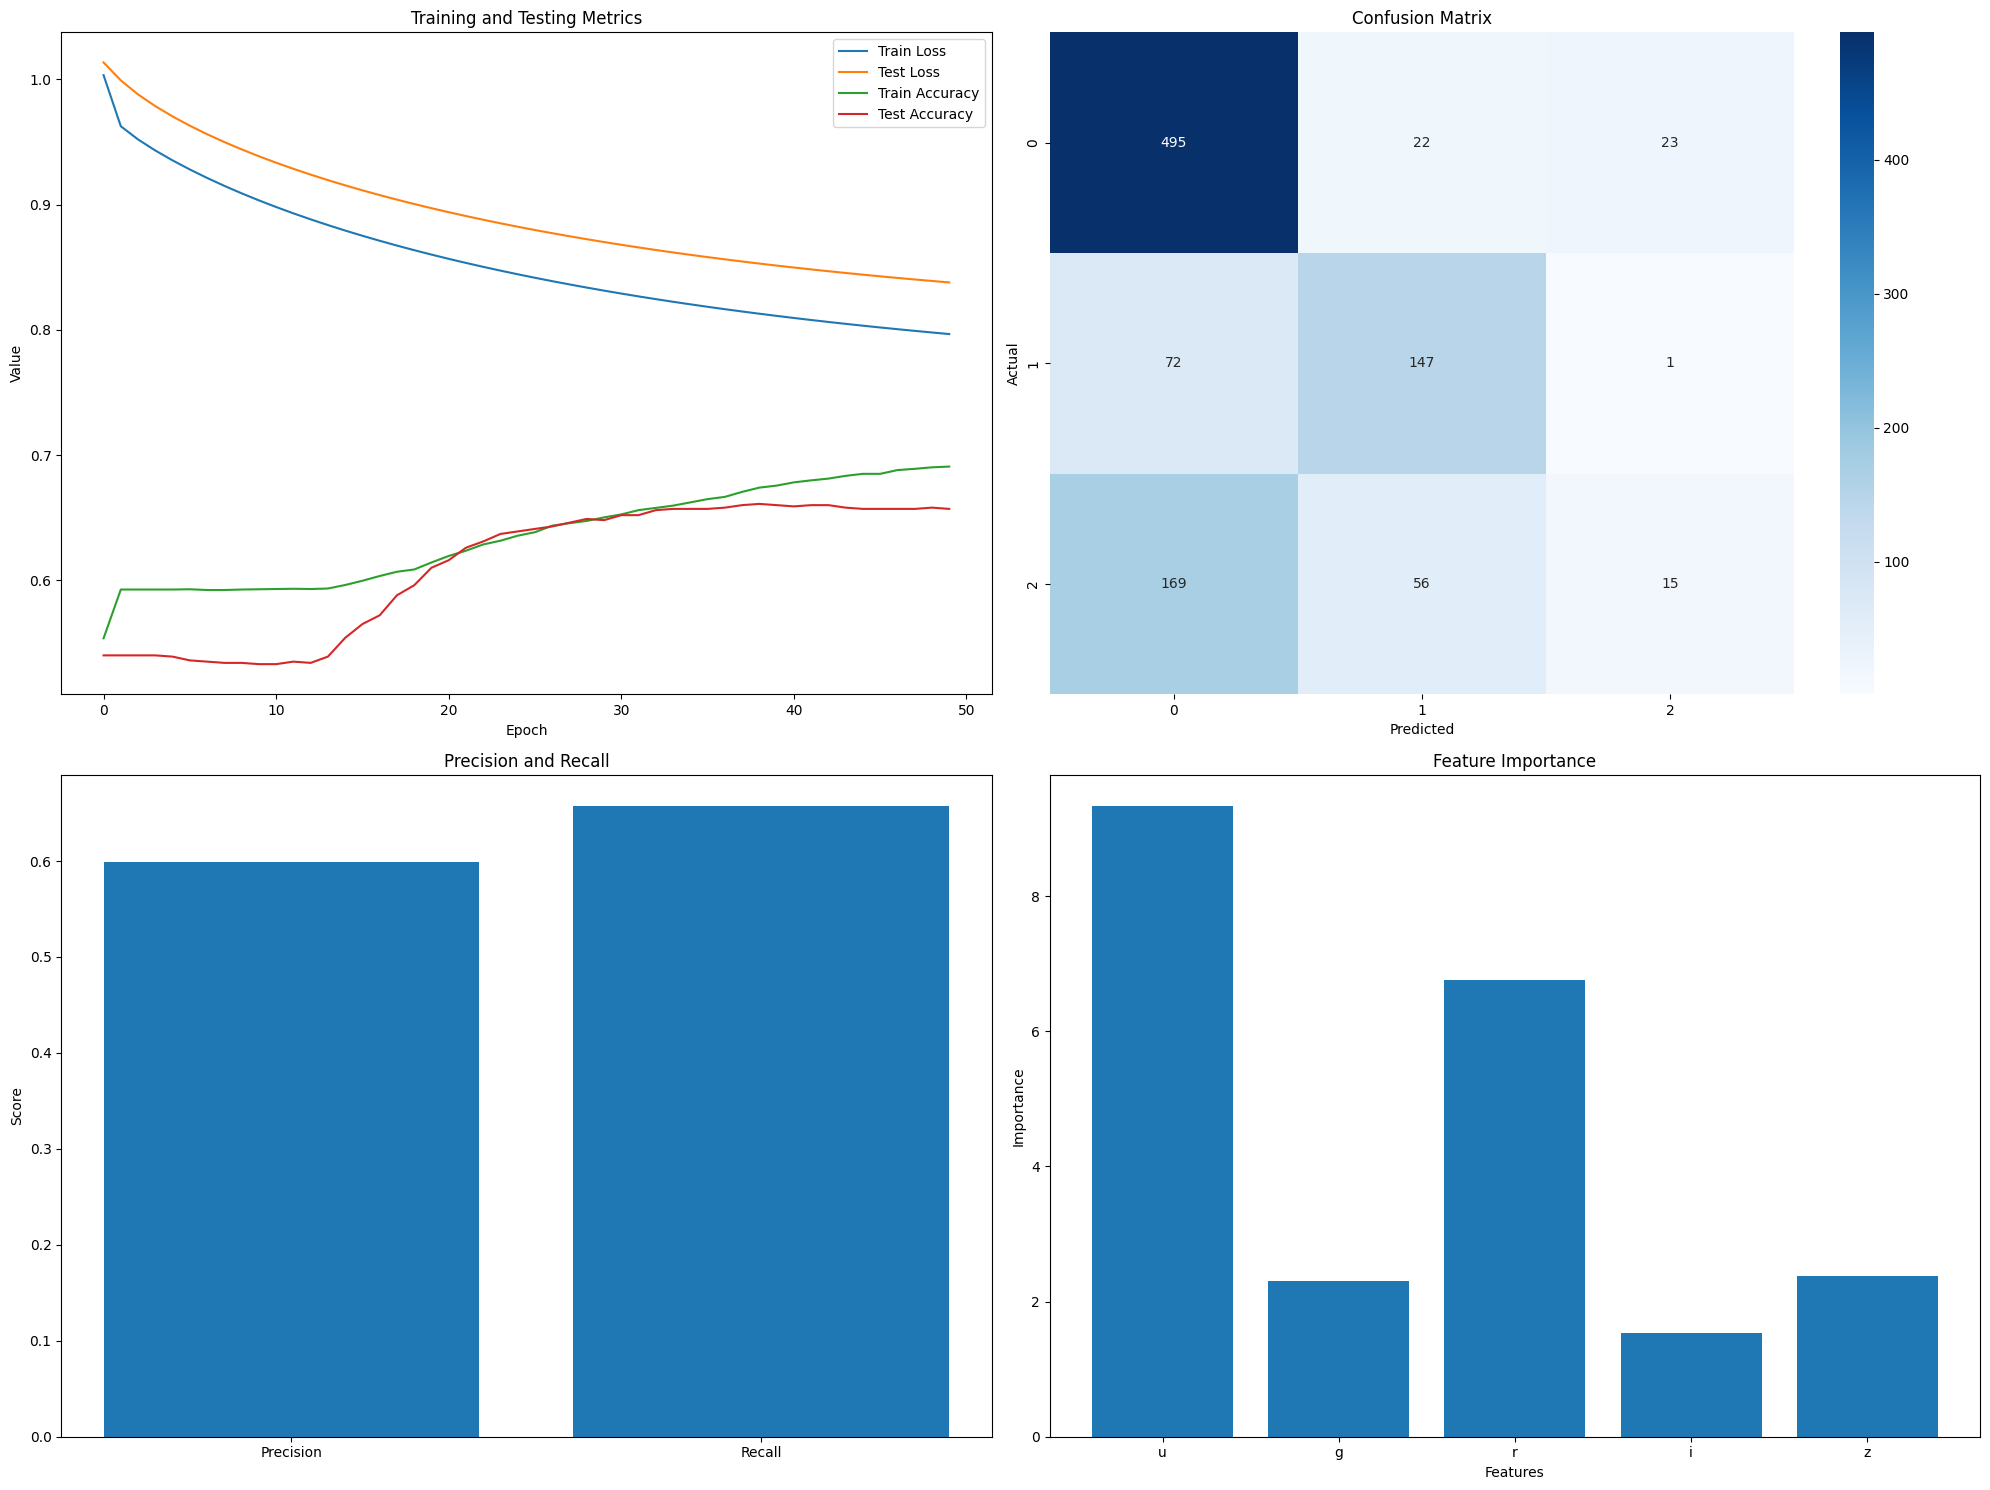

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load and preprocess the data
df = pd.read_csv('/star_classification.csv')
X = df[['u', 'g', 'r', 'i', 'z']]  # Using only the magnitude features
y = df['class']

# Encode the target variable
class_mapping = {'GALAXY': 0, 'QSO': 1, 'STAR': 2}
y = y.map(class_mapping)

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train = X_scaled[:5000]
y_train = y[:5000]
X_test = X_scaled[5000:6000]
y_test = y[5000:6000]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Define the quantum device
n_qubits = 5  # One qubit for each magnitude feature
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the QCNN model
class QCNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.fc = nn.Linear(n_qubits, 3)

    def forward(self, x):
        x = torch.tensor([quantum_circuit(x_i, self.q_layers) for x_i in x], dtype=torch.float32)
        return self.fc(x)

# Initialize the model
model = QCNN(n_qubits=n_qubits, n_layers=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 50
batch_size = 32

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_y).sum().item()

    train_loss = epoch_loss / (len(X_train) // batch_size)
    train_accuracy = correct / len(X_train)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
        _, predicted = torch.max(test_outputs.data, 1)
        test_accuracy = (predicted == y_test).sum().item() / len(y_test)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'Final Test Accuracy: {accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, predicted)
precision, recall, _, _ = precision_recall_fscore_support(y_test, predicted, average='weighted')

# Visualizations
plt.figure(figsize=(20, 15))

# Loss and Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# Confusion Matrix
plt.subplot(2, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Precision and Recall
plt.subplot(2, 2, 3)
metrics = ['Precision', 'Recall']
values = [precision, recall]
plt.bar(metrics, values)
plt.title('Precision and Recall')
plt.ylabel('Score')

# Feature Importance
plt.subplot(2, 2, 4)
feature_importance = np.abs(model.fc.weight.detach().numpy()).mean(axis=0)
features = ['u', 'g', 'r', 'i', 'z']
plt.bar(features, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()


In [ ]:
precision, recall, _, _ = precision_recall_fscore_support(y_test, predicted, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


NameError: name 'y_test' is not defined